#**MNIST using Autograd**

In [1]:
import sys, numpy as np
from keras.datasets import mnist
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import tensorflow.compat.v1 as tf 

In [7]:
#loading the mnist data into train and test sets

(x_train, y_train), (x_test, y_test) = mnist.load_data()

## **visualizations**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


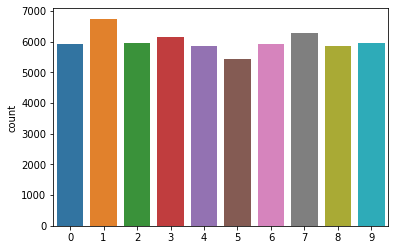

In [8]:
g = sns.countplot(y_train)

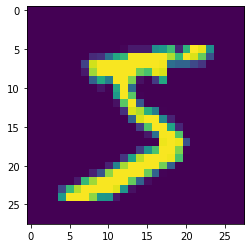

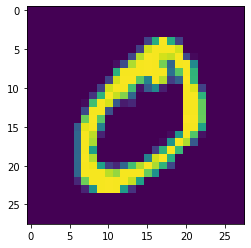

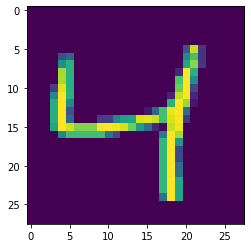

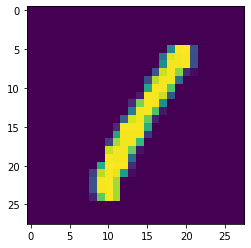

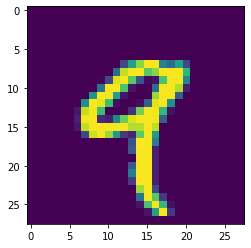

In [9]:
#visualizations of the digits in mnist

for i in range (0,5):
  plt.imshow(x_train[i])
  plt.show()

In [10]:
#reshaping and normalization

train_images = x_train[0:1000].reshape(1000,28*28)/255
test_images = x_test[0:1000].reshape(1000,28*28)/255

In [12]:
#one hot encoding the labels
from keras.utils import np_utils

train_labels = np_utils.to_categorical(y_train[0:1000], num_classes=10)
test_labels = np_utils.to_categorical(y_test[0:1000], num_classes=10)

In [30]:
import numpy as np
class Tensor (object):
    
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        if(id is None):
            self.id = np.random.randint(0,100000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
          
            assert grad.autograd == False

            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if(self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
                    
                if(self.creation_op == "sigmoid"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))
                
                if(self.creation_op == "tanh"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                
                if(self.creation_op == "relu"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                
                if(self.creation_op == "index_select"):
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))
                    
                if(self.creation_op == "cross_entropy"):
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx))
                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if(self.autograd):
            return Tensor(1 / (1 + np.exp(-self.data)),
                          autograd=True,
                          creators=[self],
                          creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if(self.autograd):
            return Tensor(np.tanh(self.data),
                          autograd=True,
                          creators=[self],
                          creation_op="tanh")
        return Tensor(np.tanh(self.data))
    
    def index_select(self, indices):

        if(self.autograd):
            new = Tensor(self.data[indices.data],
                         autograd=True,
                         creators=[self],
                         creation_op="index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])
   
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())

In [43]:
class Tanh(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.tanh()
    
class Sigmoid(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.sigmoid()

In [53]:
import numpy
np.random.seed(0)

data = Tensor(train_images, autograd=True)
target = Tensor(train_labels, autograd=True)

model = Sequential([Linear(784,528), Tanh(), Linear(528,128), Tanh(), Linear(128, 64), Sigmoid(), Linear(64, 10), Sigmoid()])
criterion = MSELoss()

optim = SGD(parameters=model.get_parameters(), alpha=0.001)

for i in range(200):
    
    # Predict
    pred = model.forward(data)
    
    # Compare
    loss = criterion.forward(pred, target)
    
    # Learn
    loss.backward(Tensor(np.ones_like(loss.data)))
    optim.step()
    print(np.mean(loss.data))

244.44028637614792
94.07128286112028
93.33555006464695
92.62507114243519
91.86349428248758
91.05534603445905
90.18435220394807
89.22253289116325
88.1559605763798
86.99232895441116
85.74842374171119
84.43111381667521
83.03193322385103
81.54033009304923
79.9551239306166
78.2863952174103
76.55215082582012
74.77295934259753
72.96765820274928
71.15224741896353
69.34117475308703
67.5486332652503
65.78818087840196
64.07130201509797
62.40662252620086
60.800084453780094
59.25537052904049
57.77417341202007
56.35632973308439
55.00001827934157
53.70214525987923
52.45883275529652
51.265860163067984
50.11898339426765
49.01413181864076
47.947516969679626
46.91568991256486
45.915571580147606
44.94446589291398
44.00005865338953
43.08040373894106
42.18389993257193
41.3092607121162
40.45548003381986
39.62179402124477
38.807641248509164
38.012620903369125
37.23645361368749
36.47894350971631
35.73994765302359
35.01934810077945
34.3170336540206
33.632881925391246
32.966751758699395
32.31847162927663
31.6878

##**Unit tests**

In [63]:
x = Tensor([3,4,5,6], autograd=True)
y = Tensor([1,1,1,1], autograd=True)
z = Tensor([6,5,4,3], autograd=True)

a = x + y
b = y + z
c = a + b

c.backward(Tensor(np.array([3,3,3,3])))
print(c.grad.data != np.array([1,1,1,1]))

[ True  True  True  True]
